In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "Aquifer_Petrignano" in filename:
            print(os.path.join(dirname, filename))

/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv


In [2]:
pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9434496 sha256=ad76c9151b7d253357cdfa8ccb762c30bd21a0025eb6cc2f9dc0865586342c76
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# EDA

### Import Libraries

In [3]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt #visualization
import seaborn as sns  #visualization
%matplotlib inline


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from fbprophet import Prophet

from datetime import datetime, date
import math
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': (20,15)})

#### TimeSeries : Any dataset that is a function of time 

### Read File

In [4]:
df = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rainfall_Bastia_Umbra,4199.0,1.556633,5.217923,0.000,0.00,0.00,0.10,67.30
Depth_to_Groundwater_P24,5168.0,-26.263723,3.319858,-34.470,-28.25,-25.99,-23.82,-19.66
Depth_to_Groundwater_P25,5184.0,-25.692926,3.214165,-33.710,-27.62,-25.54,-23.43,-19.10
Temperature_Bastia_Umbra,4199.0,15.030293,7.794871,-3.700,8.80,14.70,21.40,33.00
Temperature_Petrignano,4199.0,13.739081,7.701369,-4.200,7.70,13.50,20.00,31.10
Volume_C10_Petrignano,5025.0,-29043.296726,4751.864371,-45544.896,-31678.56,-28689.12,-26218.08,0.00
Hydrometry_Fiume_Chiascio_Petrignano,4199.0,2.372517,0.589088,0.000,2.10,2.40,2.70,4.10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


### Cleaning

In [7]:
# Remove NA values
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop = True)
# remove columns that are not usefull
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'],axis = 1)


In [8]:
# change column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [9]:
# Convert date to datatime object
df['date']= pd.to_datetime(df['date'], format = '%d/%m/%Y')

In [10]:
# Assign the output and also the input features
target = df['depth_to_groundwater']
features = df.drop('depth_to_groundwater',axis = 1)

#### Visualization

<AxesSubplot:xlabel='drainage_volume', ylabel='depth_to_groundwater'>

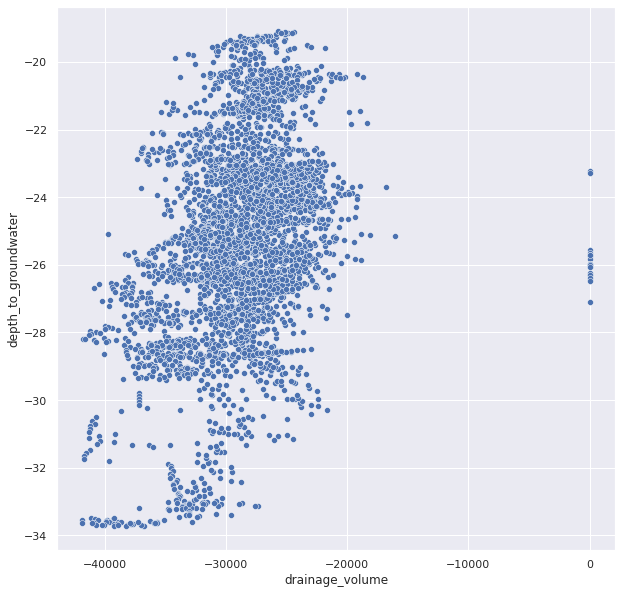

In [11]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = 'drainage_volume', y = 'depth_to_groundwater', data = df)

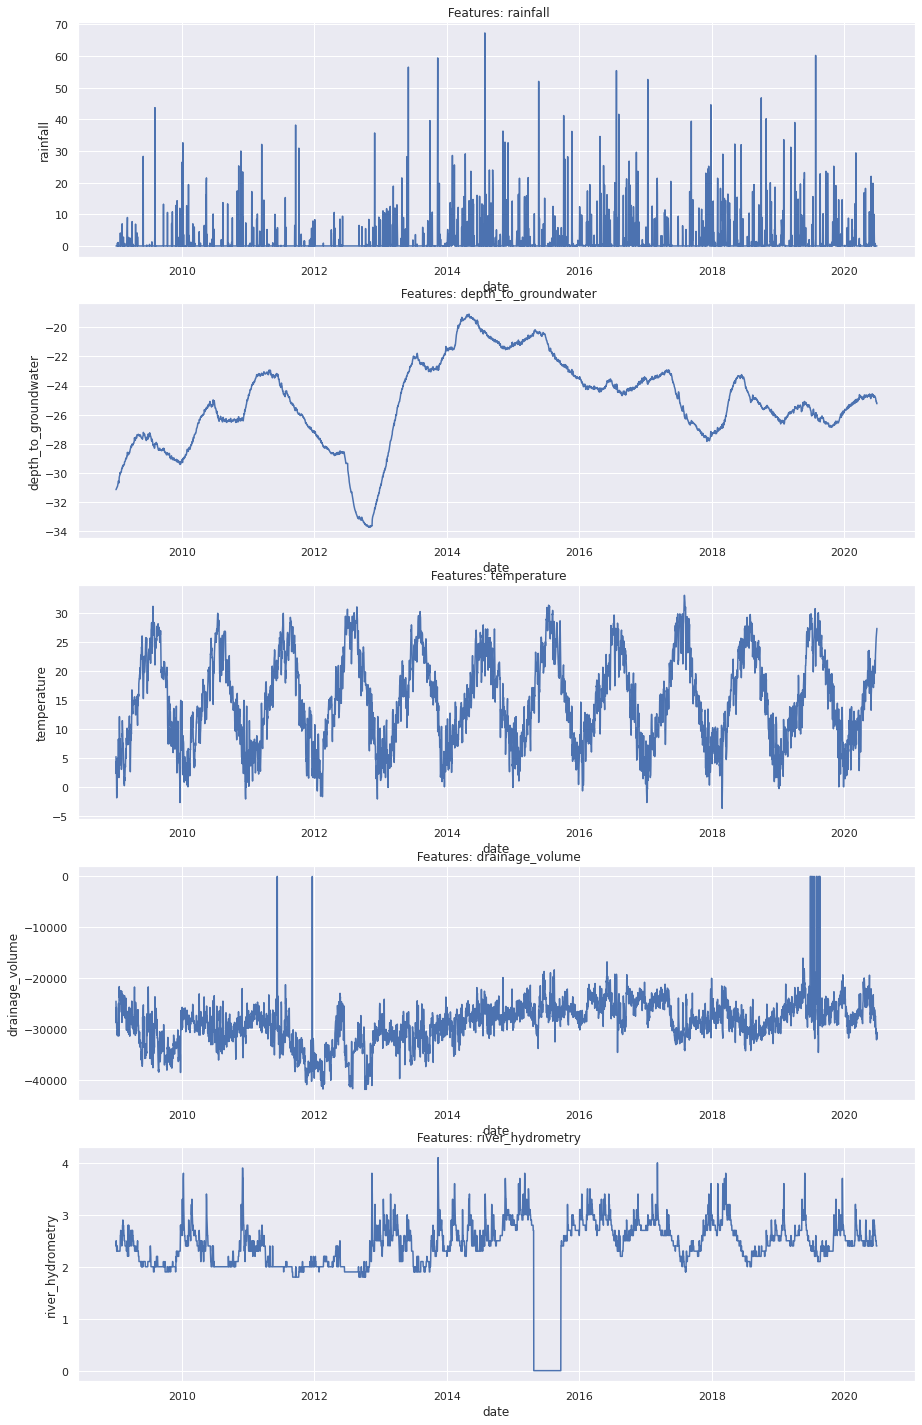

In [12]:
## See how the features (rainfall,temperature etc.) change with date
f,ax = plt.subplots(nrows = 5, ncols = 1, figsize = (15,25))

for i, column in enumerate(df.drop('date',axis = 1).columns):
    
    sns.lineplot(x = df['date'], y = df[column].fillna(method = 'ffill'), ax = ax[i])
    
    ax[i].set_title(f' Features: {column}')



In [13]:
df.isnull().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

<AxesSubplot:>

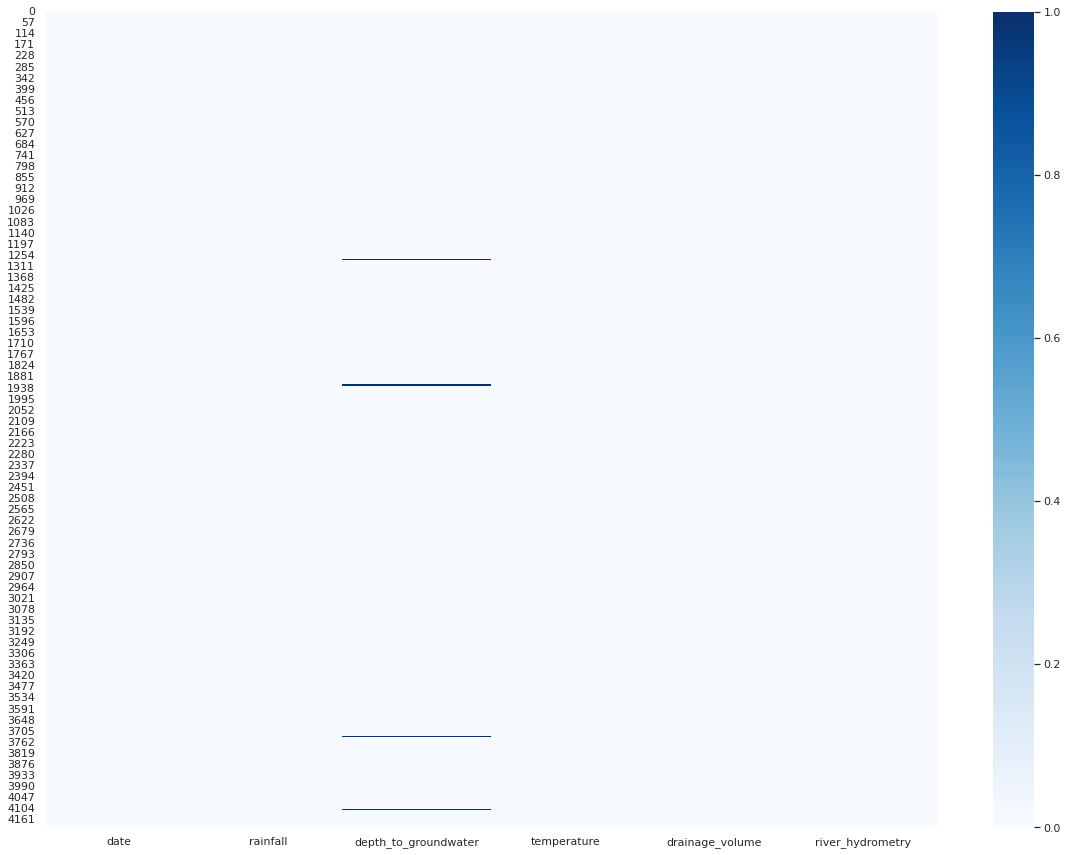

In [14]:
sns.heatmap(df.isna(), cmap = 'Blues')

#### important step while dealing with timeseries is that, it has to be in chronological order and also equidistant whatever the interval chosen

In [15]:
# sort df by date and check if its equidistant
df = df.sort_values(by = 'date')

df['Delta'] = df['date'] - df['date'].shift(1)
df['Delta'].value_counts()

1 days    4198
Name: Delta, dtype: int64

#### Ways to deal with null values in numeric features.
- Replace with Mean values
- ffill and bfill to fill values with the forward and last value
- linearly interpolated values by using .interpolate()
- Drop the rows ( only an option if the dataset is large and the # of null rows are small)

In [16]:
# To get rid of the null values, interpolate the values

df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

### Resampling 

In [17]:
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,Delta
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,NaT
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,1 days
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,1 days
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,1 days
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,1 days


#### till now we have,
- sorted the values by date
- made the data eqidistant
- handled missing data by removing few rows and then interpolating rest of the nan values by comparing 
- resample the data to smooth the curve

#### Visialization of different resampled data

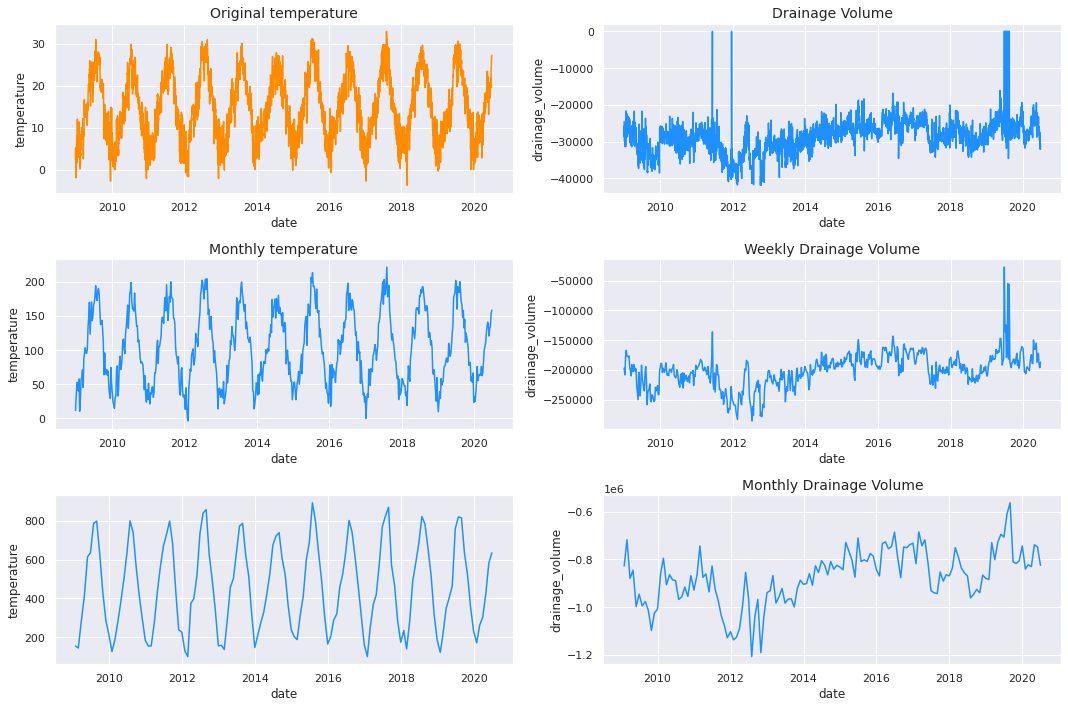

In [18]:
f, ax = plt.subplots(3,2, figsize = (15,10))

sns.lineplot(x = df['date'],y =df['temperature'], ax = ax[0,0], color = 'darkorange' )
ax[0,0].set_title("Original temperature", fontsize = 14)

resampled_temp = df[['date','temperature']].resample('7D', on = 'date').sum().reset_index(drop = False)

sns.lineplot(x = resampled_temp['date'],y =resampled_temp['temperature'], ax = ax[1,0], color = 'dodgerblue' )
ax[1,0].set_title("Weekly temperature", fontsize = 14)

resampled_tempM = df[['date','temperature']].resample('M', on = 'date').sum().reset_index(drop = False)

sns.lineplot(x = resampled_tempM['date'],y =resampled_tempM['temperature'], ax = ax[2,0], color = 'dodgerblue' )
ax[1,0].set_title("Monthly temperature", fontsize = 14)

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Drainage Volume', fontsize=14)
plt.tight_layout()


In [19]:
# Downsample
df_downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall']].resample('7D', on ='date').mean().reset_index(drop = False)

In [20]:
df = df_downsample.copy()

#### Check Stationarity

#### To use timeseries models like ARIMA, we assume stationarity in data, which means the mean and variance is constant

#### The tests can be done with few methods:

- visually: check for trends and seasoanlity
- basic statistics: partition the data and check for mean and variance
- statistical test: Augmented Dickery Fuller test

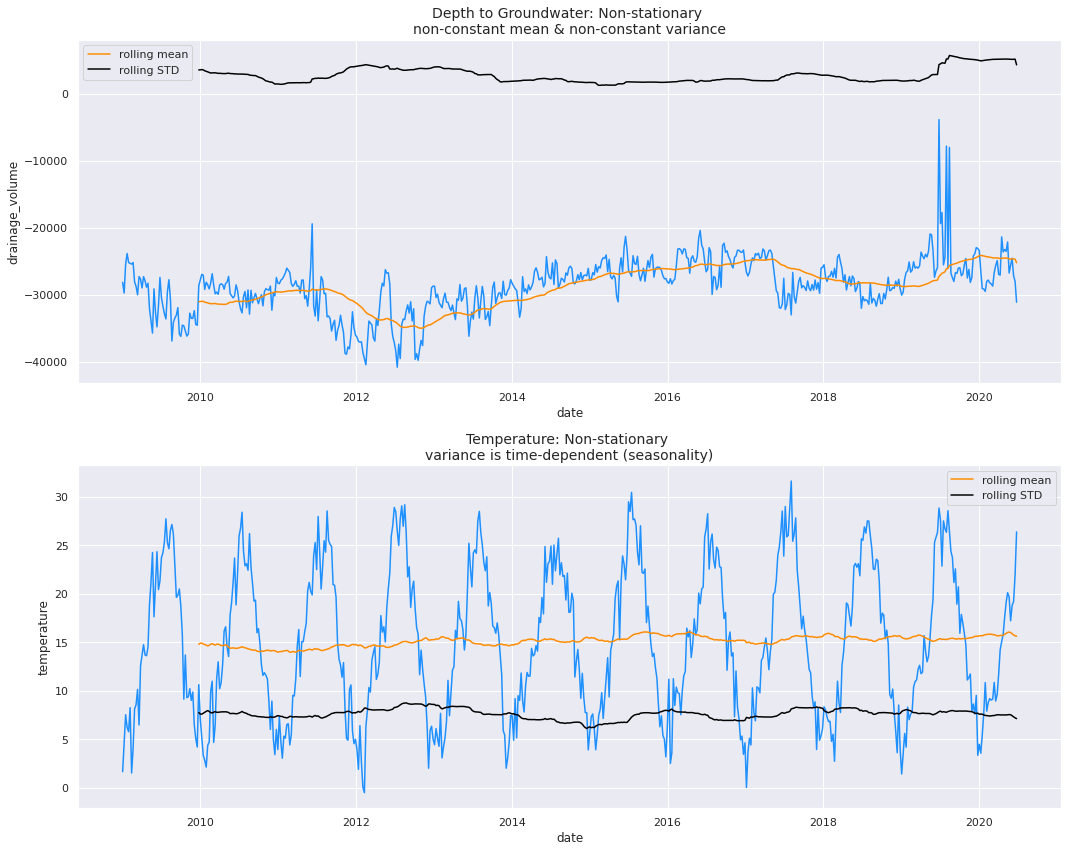

In [21]:
## visually check to see if the mean and variance is constant (stationary)

rolling_window = 52 # there are 52 weeks in 1 year

f, ax = plt.subplots(2,1,figsize = (15,12))

sns.lineplot(x = df['date'], y = df['drainage_volume'], ax = ax[0], color = 'dodgerblue')
sns.lineplot(x = df['date'], y = df['drainage_volume'].rolling(rolling_window).mean(), ax = ax[0], color = 'darkorange', label = "rolling mean")
sns.lineplot(x = df['date'], y = df['drainage_volume'].rolling(rolling_window).std(), ax = ax[0], color = 'black', label = "rolling STD")
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance',fontsize = 14)

sns.lineplot(x = df['date'], y = df['temperature'], ax = ax[1], color = 'dodgerblue')
sns.lineplot(x = df['date'], y = df['temperature'].rolling(rolling_window).mean(), ax = ax[1], color = 'darkorange',label = "rolling mean")
sns.lineplot(x = df['date'], y = df['temperature'].rolling(rolling_window).std(), ax = ax[1], color = 'black', label = "rolling STD")
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)

plt.tight_layout()
plt.show()

#### visually, we can see that it is not stationary

#### basically if the p-value is less than 5%, then it is not statistically significant which means we have to agree null hypothesis, which means it is non-stationary

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#### Adfuller Test

In [22]:
result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316661,
 0.0476991909202088,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

#### To use the ARIMA model, we need to transform the non- stationary model to stationary model,we can do that in two different ways:

- Transformation: log or square root to stabalize non-constant variance
- differencing: Subtracts the current value from the previous

#### So, since it is non-stationary suggested using the visual representation and adfuller method, we need to make it stationary.

#### Transformation

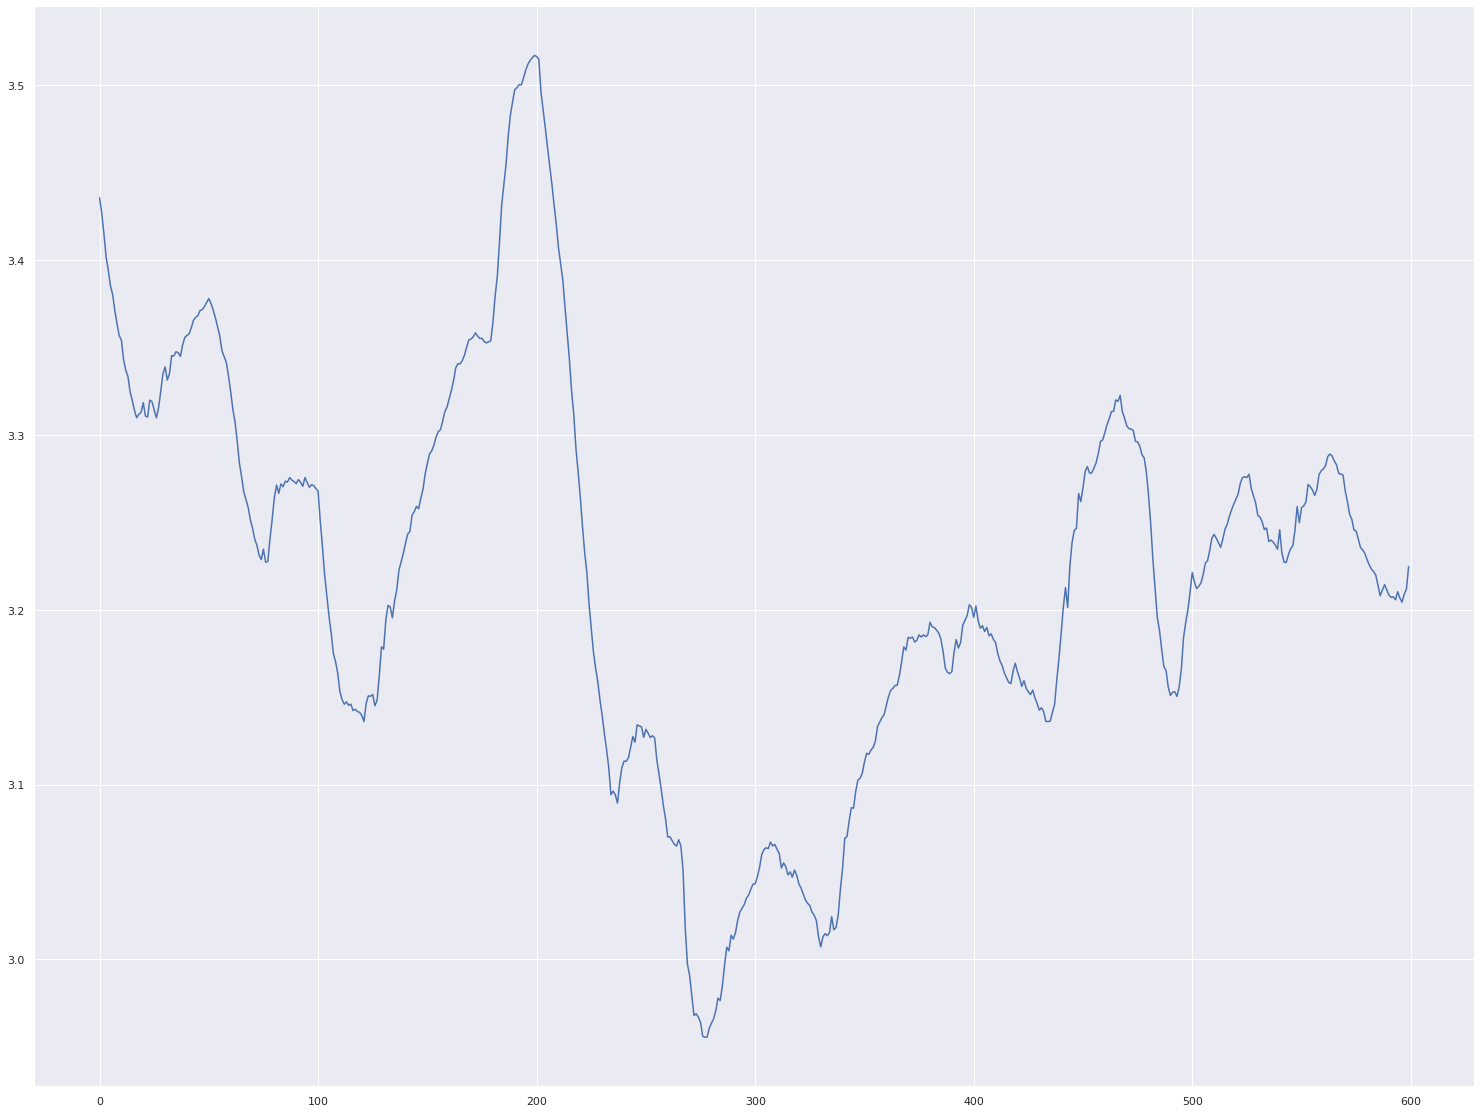

In [23]:
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))
f = plt.figure()
axes = f.add_axes([1,1,1,1])
axes.plot(df['depth_to_groundwater_log'].values)
#sns.lineplot(x = df['date'], y = df['depth_to_groundwater_log'], ax = ax[1], color = 'darkorange')

## Feature Engineering

In [24]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


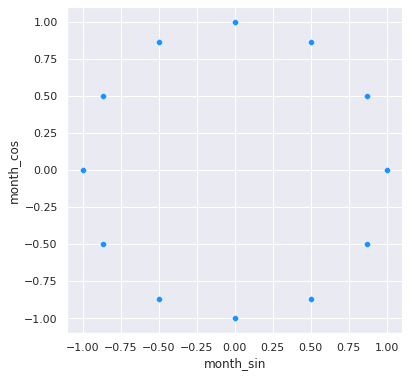

In [25]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

## TimeSeries Decomposition

In [26]:

core_columns = ['depth_to_groundwater', 'temperature', 'drainage_volume',
       'river_hydrometry', 'rainfall']

for column in core_columns:
    decomp = seasonal_decompose(df[column],model = 'additive',period = 52, extrapolate_trend = 'freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal
    

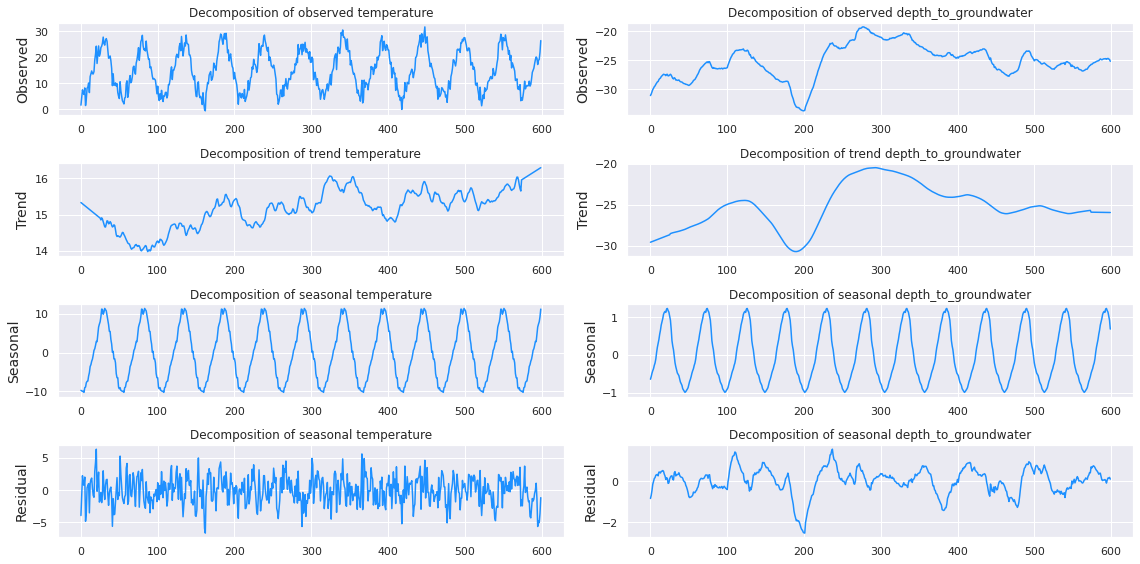

In [27]:
f,ax = plt.subplots(nrows = 4, ncols = 2, figsize = (16,8))

for i, column in enumerate(['temperature','depth_to_groundwater']):
    
    res = seasonal_decompose(x = df[column], model = 'additive', period = 52, extrapolate_trend = 'freq')
    
    ax[0,i].set_title(f"Decomposition of observed {column}")
    res.observed.plot(ax = ax[0,i],color = 'dodgerblue',legend = False)
    ax[0,i].set_ylabel("Observed", fontsize = 14)
    
    ax[1,i].set_title(f"Decomposition of trend {column}")
    res.trend.plot(ax = ax[1,i],color = 'dodgerblue',legend = False)
    ax[1,i].set_ylabel("Trend", fontsize = 14)
    
    
    ax[2,i].set_title(f"Decomposition of seasonal {column}")
    res.seasonal.plot(ax = ax[2,i],color = 'dodgerblue',legend = False)
    ax[2,i].set_ylabel("Seasonal", fontsize = 14)
    
    ax[3,i].set_title(f"Decomposition of seasonal {column}")
    res.resid.plot(ax = ax[3,i],color = 'dodgerblue',legend = False)
    ax[3,i].set_ylabel("Residual", fontsize = 14)
    
plt.tight_layout()    

In [28]:
# some important functions used with pandas 
## dateframe.rolling().mean(), dataframe.resample().mean(), dataframe.shift()

In [29]:
weeks_in_month = 4 
df['temperature_seasonal_shift_b_2m'] = df['temperature_seasonal'].shift(-2 * weeks_in_month)

In [30]:
# lag calculation, to see the correlation with each other

weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

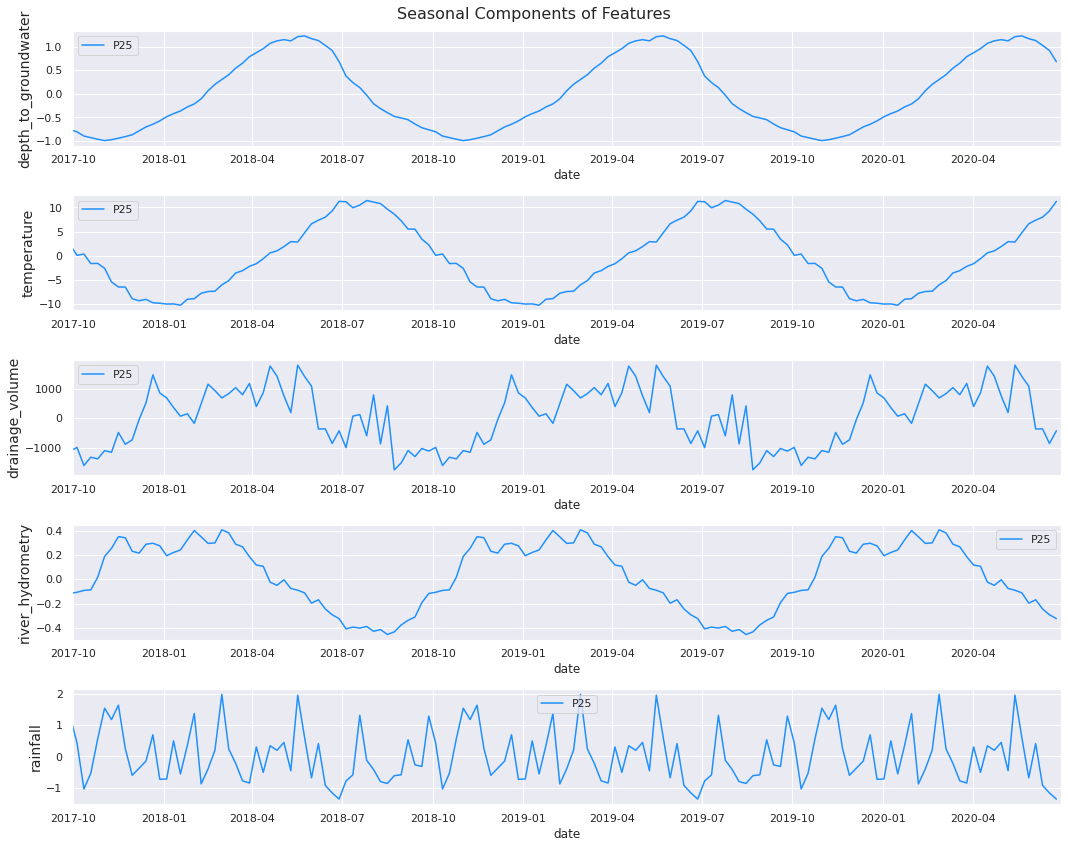

In [31]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

## Modelling

#### Split the data into Train and Test

In [32]:
# dividing the dataframe into train and valididation

train_size = int(0.85*len(df))
test_size = len(df)- train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train,y_train = pd.DataFrame(univariate_df.iloc[:train_size,0]),pd.DataFrame(univariate_df.iloc[:train_size,1])
x_valid,y_valid = pd.DataFrame(univariate_df.iloc[train_size:,0]), pd.DataFrame(univariate_df.iloc[train_size:,1])

## FBProphet for Univariant timeseries

In [33]:
# Train the model
p_model = Prophet()
p_model.fit(train)

# Predict the y values
y_pred = p_model.predict(x_valid)

# calculate metrics

score_mae = mean_absolute_error(y_valid,y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid,y_pred['yhat']))

print("\n")
print(f'RMSE: {score_rmse}')


Initial log joint probability = -6.26462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1328.21     0.0260778       1367.28           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1390.88    0.00370884       246.681           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1415.87    0.00278507       485.557           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1428.96     0.0282948       729.277           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1445.51     0.0184705       552.131           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

Text(107.25, 0.5, 'Depth to Groundwater')

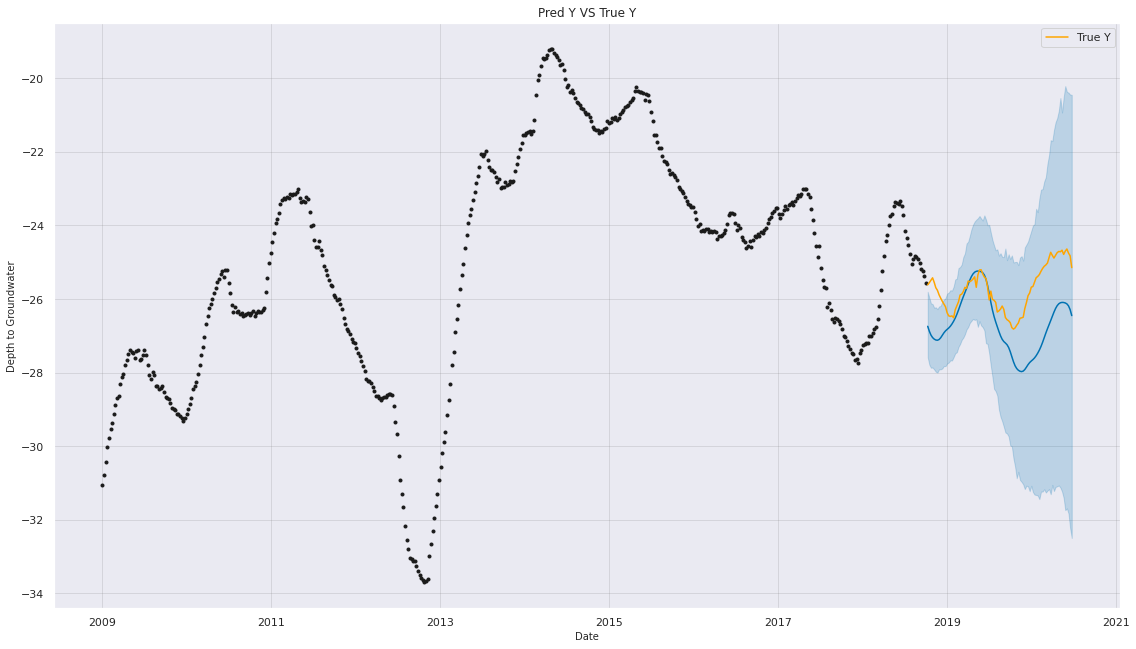

In [34]:
f, ax = plt.subplots(1,figsize = (16,9))

p_model.plot(y_pred, ax = ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax = ax, color = 'orange',label = "True Y")

ax.set_title("Pred Y VS True Y")
ax.set_xlabel(xlabel='Date', fontsize=10)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=10)

##### The task was to predict the depth of ground water for the future dates, In this above example we used phophet to forecast the future levels. But for this prediction we only used univariant to predict it.

##### that is, we used only depth of groundwater to forecast future levels.

## ARIMA Model 

In [35]:
df['depth_to_groundwater_first_diff'] = df['depth_to_groundwater'] - df['depth_to_groundwater'].shift(1)
df['depth_to_groundwater_first_diff'].iloc[0] = 0.0

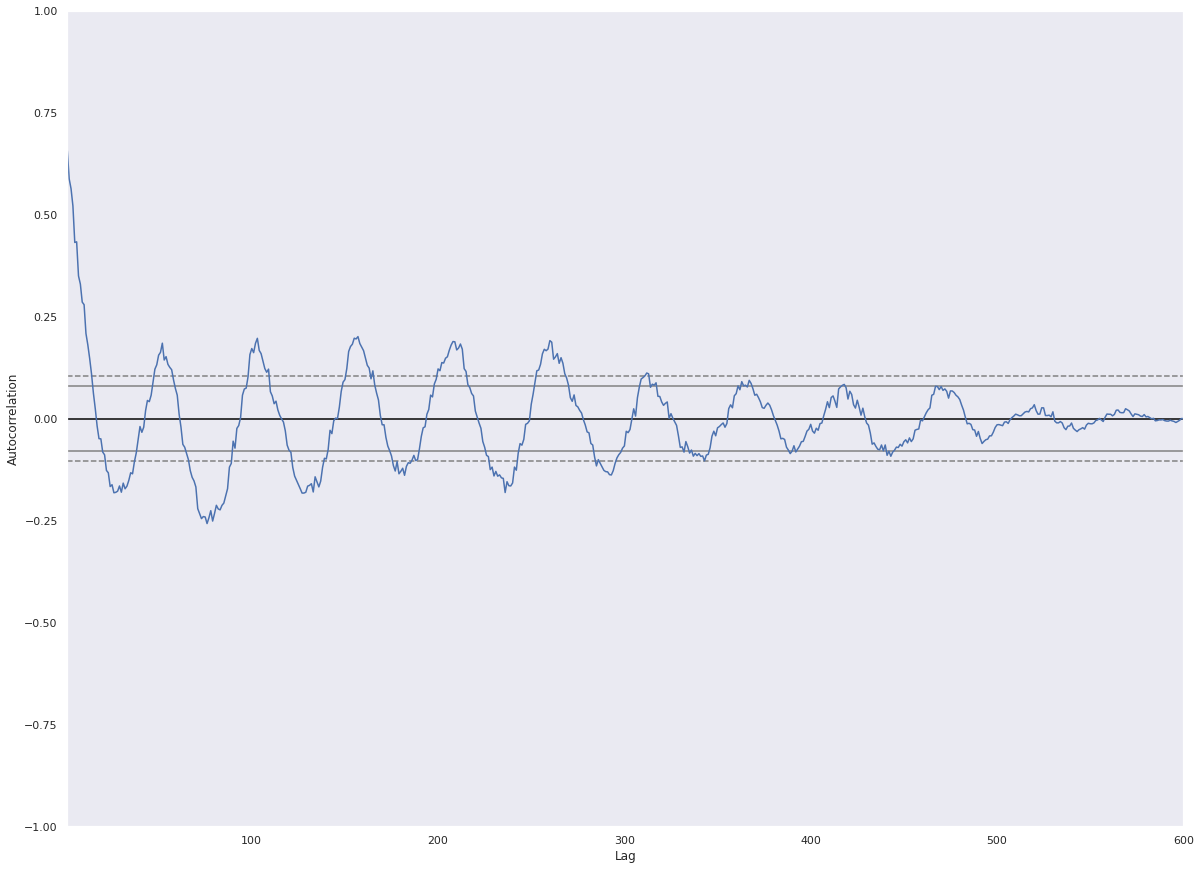

In [36]:
autocorrelation_plot(df['depth_to_groundwater_first_diff'])
plt.show()

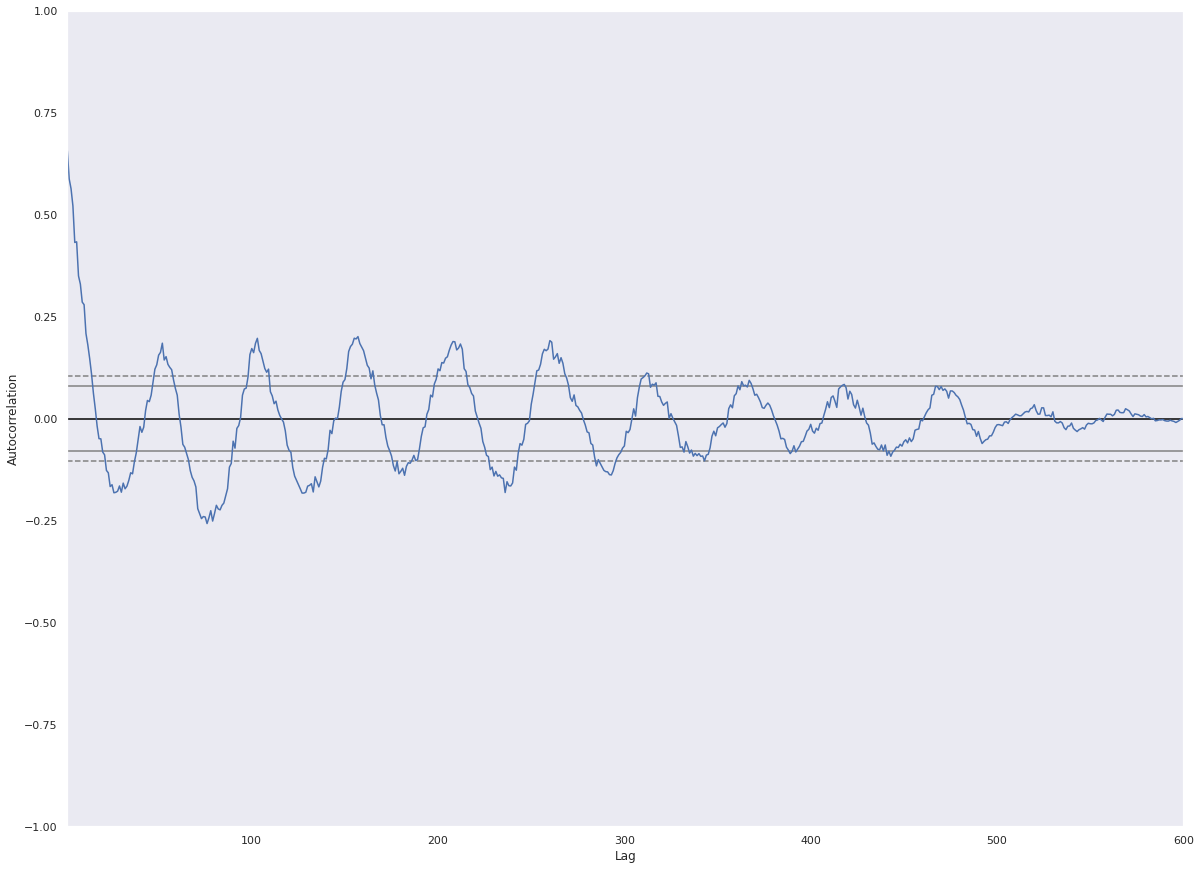

In [37]:
autocorrelation_plot(df['depth_to_groundwater_first_diff'])
plt.show()

In [38]:
A_model = ARIMA(y_train, order = (4,1,12))
model_fit = A_model.fit()
pred = model_fit.forecast(90)
df["pred Arima"] = pred

mse_arima = math.sqrt(mean_squared_error(y_valid,pred))
print(mse_arima)

0.649304956677442


In [39]:
# Predictions
pred

510   -25.667519
511   -25.740525
512   -25.835895
513   -25.891452
514   -25.915900
         ...    
595   -25.956563
596   -25.956564
597   -25.956565
598   -25.956565
599   -25.956566
Name: predicted_mean, Length: 90, dtype: float64

<AxesSubplot:xlabel='ds', ylabel='y'>

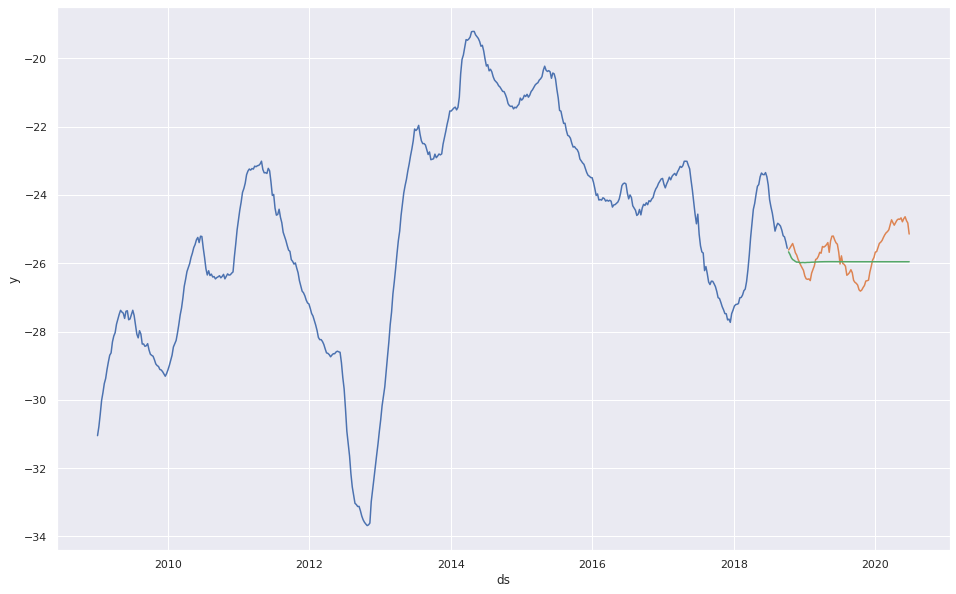

In [40]:
f, ax = plt.subplots(1,figsize = (16,10))

sns.lineplot(x = x_train['ds'], y = y_train['y'], ax= ax)
sns.lineplot(x = x_valid['ds'], y = y_valid['y'], ax= ax)
sns.lineplot(x = x_valid['ds'], y = pred, ax= ax)

## LSTM Model

In [41]:
dataset = univariate_df['y'].values.reshape(-1,1)

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [43]:
train_size = int(len(dataset)*.67)
test_size = len(dataset)- train_size

train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(dataset),len(train),len(test))

600 402 198


In [44]:
def create_dataset(dataset, look_back):
    
    dataX,dataY = [],[]
    
    for i in range(len(dataset)-look_back-1):
        
        dataX.append(dataset[i:i+look_back,0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)    

In [45]:
X_train,Y_train = create_dataset(train,52)
X_test, Y_test = create_dataset(test,52)

In [46]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))


In [47]:
model = Sequential()

model.add(LSTM(4,input_shape = (1,52)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train,Y_train,epochs = 60,verbose = 2, batch_size = 10, validation_data = (X_test,Y_test))

2022-07-26 00:15:29.885969: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-26 00:15:30.611536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
35/35 - 3s - loss: 0.3708 - val_loss: 0.1224
Epoch 2/60
35/35 - 0s - loss: 0.1095 - val_loss: 0.0077
Epoch 3/60
35/35 - 0s - loss: 0.0338 - val_loss: 0.0154
Epoch 4/60
35/35 - 0s - loss: 0.0280 - val_loss: 0.0113
Epoch 5/60
35/35 - 0s - loss: 0.0188 - val_loss: 0.0069
Epoch 6/60
35/35 - 0s - loss: 0.0103 - val_loss: 0.0049
Epoch 7/60
35/35 - 0s - loss: 0.0079 - val_loss: 0.0042
Epoch 8/60
35/35 - 0s - loss: 0.0067 - val_loss: 0.0044
Epoch 9/60
35/35 - 0s - loss: 0.0057 - val_loss: 0.0035
Epoch 10/60
35/35 - 0s - loss: 0.0050 - val_loss: 0.0033
Epoch 11/60
35/35 - 0s - loss: 0.0043 - val_loss: 0.0032
Epoch 12/60
35/35 - 0s - loss: 0.0040 - val_loss: 0.0032
Epoch 13/60
35/35 - 0s - loss: 0.0035 - val_loss: 0.0030
Epoch 14/60
35/35 - 0s - loss: 0.0032 - val_loss: 0.0026
Epoch 15/60
35/35 - 0s - loss: 0.0030 - val_loss: 0.0025
Epoch 16/60
35/35 - 0s - loss: 0.0026 - val_loss: 0.0025
Epoch 17/60
35/35 - 0s - loss: 0.0026 - val_loss: 0.0024
Epoch 18/60
35/35 - 0s - loss: 0.0023 - 

In [48]:

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print(math.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))
print(math.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))

0.32321913940481983
0.4148472732176256


In [49]:
test_predict.shape

(145, 1)

In [50]:
univariate_df["ds"].tail(145).shape

(145,)

<AxesSubplot:xlabel='ds', ylabel='y'>

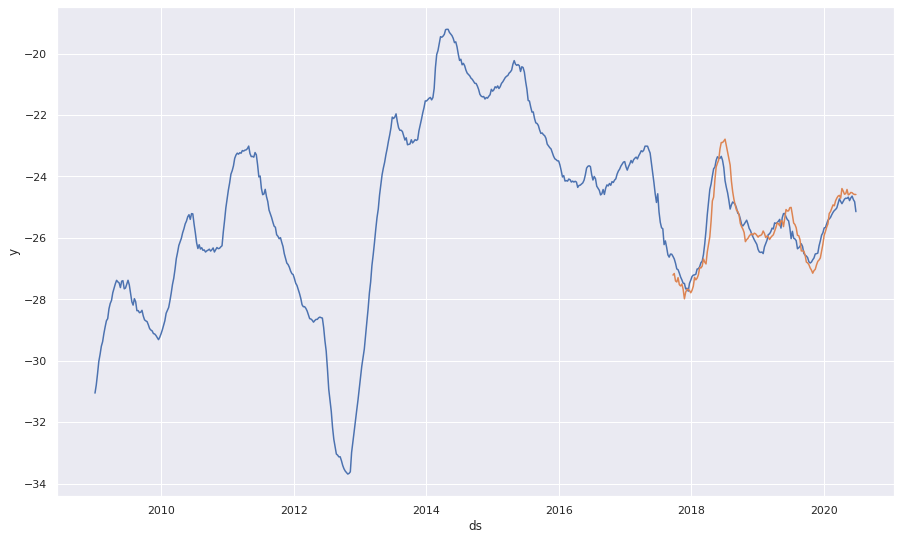

In [51]:

f, ax = plt.subplots(figsize = (15,9))
sns.lineplot(x = univariate_df["ds"],y = univariate_df["y"], ax = ax)
sns.lineplot(x = univariate_df["ds"].tail(145) ,y = test_predict[:,0], ax = ax)

## Conclusion

##### LSTM gave the best result to forecast the future groundwater lavels compared to ARIMA model and FBprophet.